In [1]:
from river import stream,tree,metrics
import utils
from encoding import prefix_bin
import csv
import copy
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import os

In [2]:
# Experiment settings

dataset_label = 'artificial_concept'
bin_n = 50
classifier = 'htc'

try:
    os.makedirs('./result/%s'%(dataset_label))
except:
    pass

In [3]:
dataset = stream.iter_csv(
            './data/IRO5k_labeled.csv',
            )

totallength = len(list(dataset))

In [4]:
# Bac drop column: drop=['END_DATE','ROLE','CLOSURE_TYPE','CLOSURE_REASON','WORKING_STATE','case_cost'],
# Articial drop column: Variant, Variant index, Resource
dataset = stream.iter_csv(
            './data/IRO5k_labeled.csv',
            drop=['Variant', 'Variant index', 'Resource'],
            target='outcome'
            )

**Event stream entry**  
----------  
**Example 1)**  
({'REQUEST_ID': '20175000168',  
  'ACTIVITY': 'Service closure Request with network responsibility',  
  'START_DATE': '2018-10-10 12:48:12.000',  
  'CE_UO': '1'},  
 '')  
   
**Example 2)**  
({'REQUEST_ID': '20175000168',  
  'ACTIVITY': 'Request completed with account closure',  
  'START_DATE': '2018-10-17 03:03:11.000',  
  'CE_UO': 'BOF'},  

'False')

In [5]:
'''
BAC key pair: 
        'REQUEST_ID':'caseid',
        'ACTIVITY':'activity',
        'START_DATE':'ts',
        'CE_UO':'resource'
'''

key_pair = {
        'Case ID':'caseid',
        'Activity':'activity',
        'Complete Timestamp':'ts',
}


case_dict ={}
training_models ={}
feature_matrix ={}
catatars= ['activity']
casecount = 0
rowcounter = 0
resultdict ={}
acc_dict ={}
running_case = 0
prediction_result = {}
graceperiod_finish=0
finishedcases = set()
usedingrace = set()

In [6]:
for x,y in dataset:
    if rowcounter%500 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
#     x['ts'] = x['ts'][:-4]
    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
#     progress = x['progress']

    x.pop('caseid')
    x.pop('outcome')
    
#     x.pop('progress')

    case_bin = prefix_bin(caseid, x)

    if caseid not in list(case_dict.keys()):
        case_bin.set_prefix_length(1)    
        case_dict[caseid] = []
    elif caseid in finishedcases:
        pass
    else:
        case_bin.set_prefix_length(len(case_dict[caseid])+1)
        case_bin.set_prev_enc(case_dict[caseid][-1])
    
    # Encode event and cases and add to DB
    case_bin.update_truelabel(outcome)   
    case_bin.update_encoded(catattrs=catatars)
    ts = case_bin.event['ts']
    case_dict[caseid].append(case_bin)
    usedingrace.add(caseid)
    # Detect label appeared case 
    if outcome != '' and caseid not in finishedcases:
        finishedcases.add(caseid)
        # Adding newly finished case to training set.    
        casecount +=1
        # Grace period to collect feature matrix
        if casecount <200:
            case_length = len(case_dict[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    training_models['prefix_%s'%(prefix+1)] = [tree.HoeffdingTreeClassifier(grace_period=100,split_criterion='info_gain'),metrics.Accuracy(), 0,0]
                feature_list = list(case_dict[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            graceperiod_finish = case_dict[caseid][-1].event['ts']
            for t in training_models.keys():
                training_models[t][3] = graceperiod_finish
            case_dict.pop(caseid)            
        else:
            break

0.0 % Case finished: 0
0.93 % Case finished: 41
1.86 % Case finished: 86
2.8 % Case finished: 138
3.73 % Case finished: 185


In [7]:
maximum_prefix = sorted([int(x.split('_')[1]) for x in training_models.keys()])[-1]

In [8]:
case_dict ={}
for x,y in dataset:
    if rowcounter%3000 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running case: %s'%(running_case))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
#     x['ts'] = x['ts'][:-4]
    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
    x.pop('caseid')
    x.pop('outcome')
    
    if caseid not in usedingrace:
        case_bin = prefix_bin(caseid, x)

        if caseid not in list(case_dict.keys()):
            case_bin.set_prefix_length(1)    
            case_dict[caseid] = []
            running_case +=1
        elif caseid in finishedcases:
            pass
        else:
            case_bin.set_prefix_length(len(case_dict[caseid])+1)
            case_bin.set_prev_enc(case_dict[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded(catattrs=catatars)
        ts = case_bin.event['ts']
        if case_bin.prefix_length >=2 and case_bin.prefix_length <= maximum_prefix:
            case_bin.encoded = utils.readjustment_training(case_bin.encoded, feature_matrix['prefix_%s'%(case_bin.prefix_length)])
            x_test = case_bin.encoded
            model = training_models['prefix_%s'%(case_bin.prefix_length)][0]
            y_pred = model.predict_one(x_test)
            if type(y_pred) != str:
                y_pred = 'False'
            modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(case_bin.prefix_length)][2]), copy.deepcopy(y_pred)
            case_bin.update_prediction((modelid, (pred_value,ts)))        
        case_dict[caseid].append(case_bin)

        # Detect label appeared case 
        if outcome != '' and caseid not in finishedcases:
            finishedcases.add(caseid)
            # Adding newly finished case to training set.    
            casecount +=1    
            # Real training start

            # Modify encoded attributes of cases with feature matrix
            case_length = len(case_dict[caseid])
            if case_length >maximum_prefix:
                case_length =maximum_prefix
            y = outcome
            for prefix in range(1, case_length):
                case_dict[caseid][prefix].update_truelabel(y)
                x = case_dict[caseid][prefix].encoded
                model = training_models['prefix_%s'%(prefix+1)][0]
                model.learn_one(x,y)
                training_models['prefix_%s'%(prefix+1)][2] +=1
                y_pred = model.predict_one(x)
                training_models['prefix_%s'%(prefix+1)][1].update(y,y_pred)

                for cases in list(case_dict.keys()):
                    if len(case_dict[cases]) >prefix:
                        x_test = case_dict[cases][prefix].encoded
                        y_pred = model.predict_one(x_test)
                        modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(prefix+1)][2]), copy.deepcopy(y_pred)
                        case_dict[cases][prefix].update_prediction((modelid, (pred_value,ts)))
                        prediction_key = str(cases)+'_'+str(prefix+1)
                        if str(cases)+'_'+str(prefix+2) not in prediction_result.keys():
                            if prediction_key not in prediction_result.keys():
                                prediction_result[prediction_key] = {}
                                prediction_result[prediction_key][modelid] = (pred_value,ts)
                            else:
                                prediction_result[prediction_key][modelid] = (pred_value,ts)
#             print(case_dict[caseid][-2].predicted)
            copying = copy.deepcopy(case_dict[caseid])
            resultdict[caseid] = copying
            case_dict[caseid] =[]
            running_case -=1

            for prefix in training_models.keys():
                if prefix not in list(acc_dict.keys()):
                    acc_dict[prefix]=[training_models[prefix][1].get()]
                else:
                    acc_dict[prefix].append(training_models[prefix][1].get())


5.59 % Case finished: 273 Running case: 10
11.18 % Case finished: 562 Running case: 6
16.78 % Case finished: 830 Running case: 8
22.37 % Case finished: 1108 Running case: 8
27.96 % Case finished: 1400 Running case: 8
33.55 % Case finished: 1680 Running case: 8
39.14 % Case finished: 1950 Running case: 6
44.74 % Case finished: 2239 Running case: 6
50.33 % Case finished: 2530 Running case: 6
55.92 % Case finished: 2800 Running case: 7
61.51 % Case finished: 3069 Running case: 9
67.11 % Case finished: 3361 Running case: 6
72.7 % Case finished: 3637 Running case: 11
78.29 % Case finished: 3907 Running case: 9
83.88 % Case finished: 4191 Running case: 7
89.47 % Case finished: 4476 Running case: 9
95.07 % Case finished: 4746 Running case: 8


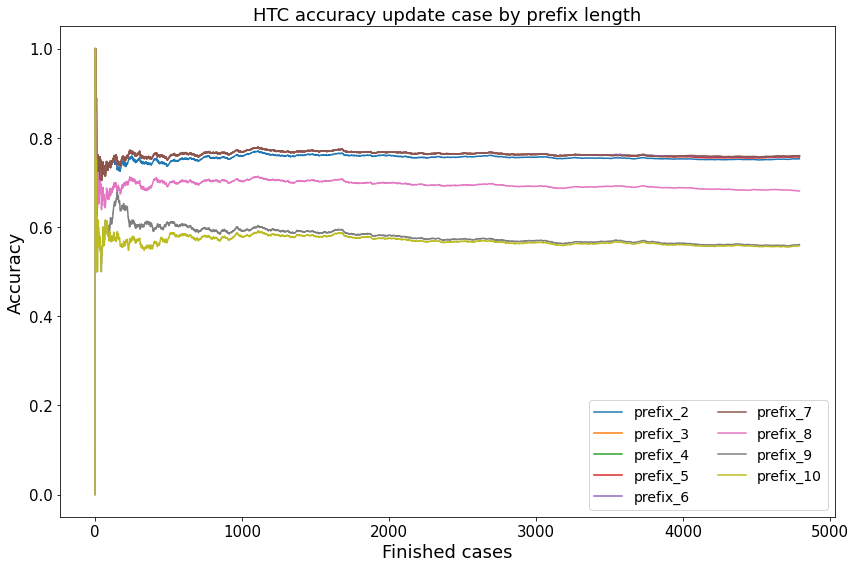

In [9]:

plt.figure(figsize=(12, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

for t in list(acc_dict.keys())[:9]:
    plt.plot(acc_dict[t], label=str(t))
    plt.legend(ncol=2,loc='lower right')
plt.title('HTC accuracy update case by prefix length')
plt.ylabel('Accuracy')
plt.xlabel('Finished cases')
plt.tight_layout()
plt.savefig('./img/htc_acc_update.png')


In [10]:
# # Continuous evaluation performance by relative time-event bin 

# bin_n = 50
# rt_bin_event_acc = {}
# y_true, target_pred = utils.rt_event_continuous_evaluation(resultdict, bin_n)

# for t in tqdm(range(2,12)):
#     bin_y_true = []
#     bin_y_pred = []
#     if 'prefix_%s'%(t) not in list(rt_bin_event_acc.keys()):
#         bin_event_acc['prefix_%s'%(t)]=[]
#     for prefix in y_true.keys():
#         if t ==int(prefix.split('_')[1]):
#             bin_y_true.append(y_true[prefix])
#             bin_y_pred.append(target_pred[prefix])
# #     print(bin_y_pred)
#     for bin_interval in range(bin_n):
#         bin_y_pred2 = [x[bin_interval] for x in bin_y_pred]
#         bin_event_acc['prefix_%s'%(t)].append(accuracy_score(bin_y_true, bin_y_pred2))

In [11]:
import utils

In [12]:
from collections import Counter
def averaged_prediction(bin_result_list):
    '''
    Get single prediction value by bin result list

    Parameters
    ----------
    bin_result_list: list
        List of predicted values of the bin
    
    Return
    ----------
    The most frequent singe value in arg max value from bin_result_list
    '''
    try:
        answer =sorted(Counter(bin_result_list).items(),key = (lambda x:x[1]),reverse=True)[0][0] 
    except:
        answer = None
    return answer

def pl_case_continuous_evaluation(resultdict):
    bin_pred = {}
    y_true = {}
    for case in tqdm(resultdict.keys()):
        if len(resultdict[case]) > 2:
            for event in range(1,len(resultdict[case])-1):
                bin_result_list = [x[0] for x in resultdict[case][event].predicted.values()]
                bin_predicted_value = averaged_prediction(bin_result_list)
                if bin_predicted_value != None:
                    y_true[str(case)+'_'+str(event+1)] = resultdict[case][event].true_label
                    bin_pred[str(case)+'_'+str(event+1)] = bin_predicted_value
    return y_true, bin_pred


In [13]:
# Continuous evaluation performance by prefix length-case bin 

y_true, target_pred = utils.pl_case_continuous_evaluation(resultdict)
bin_event_acc = {}
max_length = max([len(x) for x in resultdict])
print(max_length)

for prefix in tqdm(list(y_true.keys())):
    t = int(prefix.split('_')[1])
    if t in range(2,11):
        if '%s'%(t) not in list(bin_event_acc.keys()):
            bin_event_acc['%s'%(t)] ={'y_true':[],'y_pred':[]}
        else:
            bin_event_acc['%s'%(t)]['y_true'].append(y_true[prefix])
            bin_event_acc['%s'%(t)]['y_pred'].append(target_pred[prefix])
for prefix in bin_event_acc.keys():
    bin_event_acc[prefix]= accuracy_score(bin_event_acc[prefix]['y_true'], bin_event_acc[prefix]['y_pred'])

100%|██████████| 36933/36933 [00:00<00:00, 1027188.41it/s]

8


In [14]:
print(bin_event_acc)

{'2': 0.5942028985507246, '4': 0.7323943661971831, '5': 0.8615384615384616, '3': 0.7076923076923077, '6': 0.7222222222222222, '7': 0.38271604938271603, '10': 0.7613636363636364, '8': 0.8333333333333334, '9': 0.527027027027027}


In [15]:
def rt_case_continuous_evaluation(resultdict, bin_n):
    bin_pred = {}
    y_true = {}
    for case in tqdm(resultdict.keys()):
        if len(resultdict[case]) > 2:
            prediction_counter = 0
            prediction_by_bin ={}
            start_ts = resultdict[case][1].event['ts']
            end_ts = resultdict[case][-1].event['ts']
            bin_list = utils.get_ts_bin_list(start_ts, end_ts, bin_n)
            for event in range(1,len(resultdict[case])-1):
                for predict in resultdict[case][event].predicted.keys():
                    prediction_by_bin[prediction_counter] = resultdict[case][event].predicted[predict]
                    prediction_counter +=1
            t = utils.ts_averaged_prediction_by_bin(bin_list,prediction_by_bin)
            for each_bin in [x for x in t.keys()]:                
                y_true[str(case)+'_'+str(each_bin[2]+1)]=resultdict[case][event].true_label
                bin_pred[str(case)+'_'+str(each_bin[2]+1)]= t[each_bin]
            
    return y_true, bin_pred

In [16]:
# Continuous evaluation performance by relative time-case bin 

bin_n = 50
rt_bin_event_acc = {}
y_true, target_pred = utils.rt_case_continuous_evaluation(resultdict, bin_n)

            
for prefix in tqdm(list(y_true.keys())):
    t = int(prefix.split('_')[1])
    if '%s'%(t) not in list(rt_bin_event_acc.keys()):
        rt_bin_event_acc['%s'%(t)] ={'y_true':[],'y_pred':[]}
    else:
        rt_bin_event_acc['%s'%(t)]['y_true'].append(y_true[prefix])
        rt_bin_event_acc['%s'%(t)]['y_pred'].append(target_pred[prefix])

for prefix in rt_bin_event_acc.keys():
    rt_bin_event_acc[prefix]= accuracy_score(rt_bin_event_acc[prefix]['y_true'], rt_bin_event_acc[prefix]['y_pred'])

100%|██████████| 239650/239650 [00:02<00:00, 93796.48it/s] 


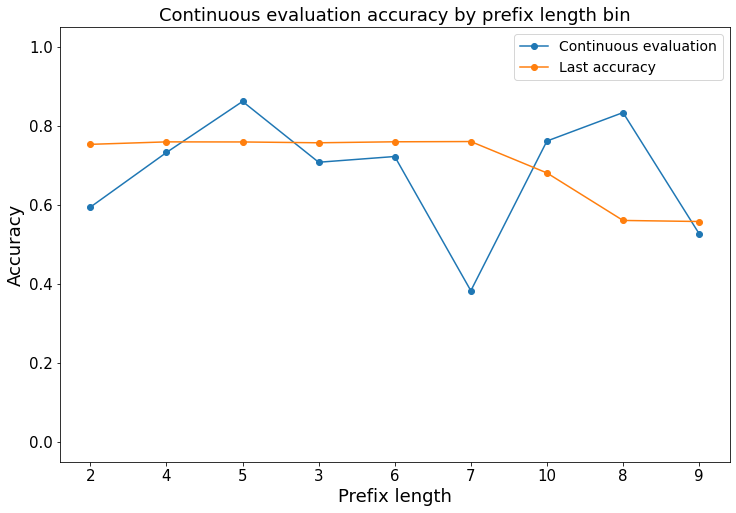

In [17]:
plt.figure(figsize=(12, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

axes = plt.gca()
axes.set_ylim([-0.05, 1.05])

x,ce_acc_y = list(bin_event_acc.keys()),[bin_event_acc[x] for x in bin_event_acc.keys()]
last_acc_y = [acc_dict[x][-1] for x in list(acc_dict.keys())[:9]]
plt.plot(x,ce_acc_y,'-o',label='Continuous evaluation')
plt.plot(x,last_acc_y, '-o',label = 'Last accuracy')

y_gap = [[t, last_acc_y[pos]] if t<= last_acc_y[pos] else (last_acc_y[pos], t) for pos,t in enumerate(ce_acc_y)]
# for pos in range(len(y_gap)):
#     if y_gap[pos][0] ==0:
#         y_gap[pos][0] = 0.05
#     if y_gap[pos][1] ==0:
#         y_gap[pos][1] = 0.05
plt.title('Continuous evaluation accuracy by prefix length bin')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Prefix length')
    

plt.savefig('./img/%s continuous acc.png'%(classifier))


with open('./result/%s/%s_continuous_evaluation_plbin.pkl'%(dataset_label,classifier),'wb') as f:
    pkl.dump([x,ce_acc_y],f)

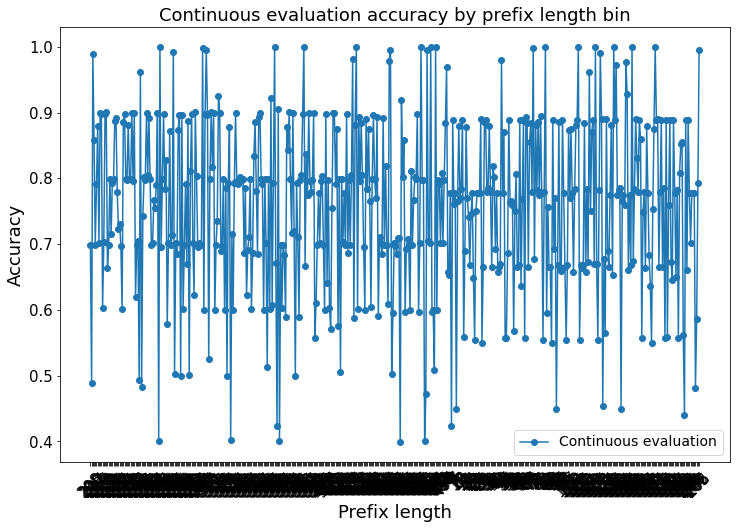

In [18]:
plt.figure(figsize=(12, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

axes = plt.gca()
# axes.set_ylim([0.92, 0.94])
x,ce_acc_y = list(rt_bin_event_acc.keys()),[rt_bin_event_acc[x] for x in rt_bin_event_acc.keys()]
plt.plot(x,ce_acc_y,'-o',label='Continuous evaluation')
# plt.plot(x,last_acc_y, '-o',label = 'Last accuracy')

plt.title('Continuous evaluation accuracy by prefix length bin')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Prefix length')
plt.xticks(rotation='45')
    
plt.show()
# plt.savefig('./img/HTC continuous acc.png')

with open('./result/%s/%s_continuous_evaluation_rt%sbin.pkl'%(dataset_label,classifier,bin_n),'wb') as f:
    pkl.dump([x,ce_acc_y],f)